# BE/Bi 103, Fall 2018: Homework 5
## Due 1pm or 7pm, Sunday, November 4

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="../data/caltech_rosen.png">

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw5.ipynb).*

## Problem 5.1: Hacker stats and Darwin's finches (100 pts)

Peter and Rosemary Grant of Princeton University have visited the island of Daphne Major on the Galápagos every year for over forty years and have been taking a careful inventory of the finches there. The Grants recently published a wonderful book,  [40 years of evolution: Darwin's finches on Daphne Major Island](http://www.worldcat.org/oclc/854285415). They were generous and made their data publicly available on the [Dryad data repository](http://dx.doi.org/10.5061/dryad.g6g3h). (In general, it is a very good idea to put your published data in public data repositories, both to preserve the data and also to make your findings public.) We will be using this data set to learn about evolution of Darwin's finches and use your hacker statistics skills. Up until part (f), all of your analyses will use nonparametric frequentist hacker stats.

We will focus on the primary two species of ground finch on Daphne Major, *Geospiza fortis* and *Geospiza scandens*. In this [data set](../data/finch_beaks.csv), you will find measurements of the beak length (tip to base) and beak depth (top to bottom) of these finches in the years 1973, 1975, 1987, 1991, and 2012. Also included in that data set is the band number for the bird, which gives a unique identifier.

In [1]:
import sys

import numpy as np
import pandas as pd 
import numba

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Pevent bulky altair plots
alt.data_transformers.enable('json')

import bebi103
import bokeh
import bokeh.plotting
import bokeh.io
from bokeh.palettes import all_palettes 
from bokeh.models import Legend, LegendItem
import itertools
bokeh.io.output_notebook()

Loading BokehJS ...

**a)** We start with a little tidying of the data. Think about how you will deal with duplicate measurements of the same bird and make a decision on how those data are to be treated.

In [2]:
# Load the data into DataFrame df
df = pd.read_csv('../data/finch_beaks.csv', comment = "#")

# Check for duplicates
df["Duplicates"] = df.duplicated()

# Remove the three that were found
df = df[df["Duplicates"] == False]
df = df.reset_index()
df = df.drop(columns = ["index"])

# Check for duplicates where a different measurement was found for the same bird
df["Duplicates"] = df.duplicated(subset = ["band", "year"], keep = False)

# Throw out the ones that were different species, and average the one with 2 values.
df = df.drop(df.index[[103, 2054, 2175]])
df.at[102, "beak depth (mm)"] = 9.77
df = df.reset_index()
df = df.drop(columns = ["index", "Duplicates"])

# Finalize Tidy Dataframe
df_tidy = df[['band',
              'year',
              'species',
              'beak length (mm)', 
              'beak depth (mm)']]
df_tidy.head()

,band,year,species,beak length (mm),beak depth (mm)
0,20123,1973,fortis,9.25,8.05
1,20126,1973,fortis,11.35,10.45
2,20128,1973,fortis,10.15,9.55
3,20129,1973,fortis,9.95,8.75
4,20133,1973,fortis,11.55,10.15


Also, I'm going to import some functions from the tutorials so that I can efficiently take bootstrap samples later in the problem. 

In [3]:
@numba.jit(nopython=True)
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))

@numba.jit(nopython=True)
def draw_bs_reps_mean(data, size=1):
    """
    Draw boostrap replicates of the mean from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return out

**d)** Devise a measure for the *shape* of a beak. That is, invent some scalar measure that combines both the length and depth of the beak. Compare this measure between species and through time. (This is very open-ended. It is up to you to define the measure, make relevant plots, compute confidence intervals, and possibly do hypothesis tests to see how shape changes over time and between the two species.)

I think that an interesting measure of beak shape would be constant for any given organism over time, but perhaps would be variable for a population or across species. To this end, I want to look at the relationship between the two measurements on the same bird over time, and see if beak growth (or decay) is common among each bird. 

In [4]:
bird_ids = np.unique(df_tidy["band"].values)
print("There are %i different birds in the study." %len(bird_ids))

# Array of the form (lifespan, num_measurements)
lifespans = np.zeros([len(bird_ids), 2])

for i, id_num in zip(range(0, len(bird_ids)), bird_ids):
    df_single_bird = df_tidy[df_tidy["band"] == id_num]
    arr_single_bird = df_single_bird["year"].values
    lifespans[i][0] = np.max(arr_single_bird) - np.min(arr_single_bird)
    lifespans[i][1] = len(arr_single_bird)
print("Average bird lifespan: %.2f           Standard Dev: %.2f" 
      % (np.average(lifespans[...,0]), np.std(lifespans[...,0])))
print("Average number of measurements: %.2f  Standard Dev: %.2f" 
      % (np.average(lifespans[...,1]), np.std(lifespans[...,1])))

There are 1953 different birds in the study.
Average bird lifespan: 0.71           Standard Dev: 1.56
Average number of measurements: 1.18  Standard Dev: 0.38


It seems like most of our birds did not survive to the second measurement, but finches should live longer than a year. What happened?

In [5]:
bird_years = np.unique(df_tidy["year"].values)
print("Years we have measurements for: %i" %len(bird_years))
print("Duration of experiment: %i" %(2012 - 1973 + 1))

Years we have measurements for: 5
Duration of experiment: 40


At best, we only have measurements that were taken every 8 years. This will make developing a shape independent of the growth of individual finches very difficult, given that we are unlikely to have more than 2 datapoints for any finch. Furthermore, this reveals that our above calculation for the average finch lifespan is roughly nonsense. 

At this point, it seems better to try and find an intuitive measure of beak shape, rather than struggle against limited data to find a more complex model. We will take a simple ratio, because we would like the shape to be independent of size. We expect that beak depth will have slightly less variability, so this shall be the denominator. Thus:
$$\text{Shape } = s = \frac{\text{beak length}}{\text{beak depth}}$$
I will add this parameter to the dataframe. 

In [6]:
df_tidy.loc[:,"Shape"] = (df_tidy.loc[:,"beak length (mm)"] / df_tidy.loc[:,"beak depth (mm)"])
df_tidy.head()

/Users/john/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/john/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,band,year,species,beak length (mm),beak depth (mm),Shape
0,20123,1973,fortis,9.25,8.05,1.149068
1,20126,1973,fortis,11.35,10.45,1.086124
2,20128,1973,fortis,10.15,9.55,1.062827
3,20129,1973,fortis,9.95,8.75,1.137143
4,20133,1973,fortis,11.55,10.15,1.137931


Now I will make a plot that displays the distribution of beak shape across species and time. 

In [7]:
bird_species = np.unique(df_tidy["species"].values)
# Deals with coloring of different lines
colors = all_palettes['Viridis'][10]

first = True # used to only show the first plot. 

p = bokeh.plotting.Figure(width = 800, 
                          height = 500,
                          title = "Beak shape across time and species",
                          x_axis_label = "Beak Shape")

plots = [0] * len(bird_years)

for year, index in zip(bird_years, range(0, len(bird_years))):
    
    name = str(year)
    
    df_temp = df_tidy[df_tidy["year"] == year]
    df_temp_1 = df_temp[df_temp["species"] == bird_species[0]]
    df_temp_2 = df_temp[df_temp["species"] == bird_species[1]]
    p = bebi103.viz.ecdf(df_temp_1["Shape"].values, p=p, 
                         color=colors[index], visible = first, 
                         legend = name +" "+ bird_species[0])
    p = bebi103.viz.ecdf(df_temp_2["Shape"].values, p=p, 
                         color=colors[index + 5], visible = first, 
                         legend = name +" "+ bird_species[1])
    
    p.legend.click_policy = 'hide'
    p.legend.location = "bottom_right"
    first = False # used to only show the first plot. 

bokeh.io.show(p)

We will compute the mean beak shape for every year and species. Since we are working on a larger number of datasets than in part b, let's define a function that can take as its arguments the dataframe, the year, and the species and return a print statement describing the mean beak length for that slice. We can also include the confidence interval using our bootstrapping methods

In [8]:
def mean_beak_shape(df, year, species):
    """Finds the mean beak shape for a given year and species, and
       returns it along with a confidence interval."""
    # Isolate species and year
    df_year = df.loc[df["year"] == year]
    dataset_species = df_year.loc[df_year["species"] == species, 
                                  "Shape"].values
    # Calculate mean
    mean = np.mean(dataset_species)
    
    # Calculate 95% confidence interval for mean. 
    bs_mean_shape = draw_bs_reps_mean(dataset_species, size=10000)
    mean_shape_conf_int = np.percentile(bs_mean_shape, [2.5, 97.5])
    return (mean, mean_shape_conf_int)

def print_beak_shape(species, year, mean, mean_shape_conf_int):
    """Helper function to report beak shapes."""
    print("The mean beak shape for {0:.8s} in {1:.0f} is {2:.2f},".format(*(species, year, mean)))
    print("with a 95% confidence interval of: [{0:.2f}, {1:.2f}]".format(*(tuple(mean_shape_conf_int))))

Now let's execute that on our dataset to see the mean beak shape for each species in each year:

In [19]:
names = ["fortis", "scandens"]
years = [1973, 1975, 1987, 1991, 2012]

for species in names:
    for year in years:
        (mean, mean_shape_conf_int) = mean_beak_shape(df_tidy, year, species)
        print_beak_shape(species, year, mean, mean_shape_conf_int)
        

The mean beak shape for fortis in 1973 is 1.12,
with a 95% confidence interval of: [1.10, 1.13]
The mean beak shape for fortis in 1975 is 1.15,
with a 95% confidence interval of: [1.15, 1.16]
The mean beak shape for fortis in 1987 is 1.18,
with a 95% confidence interval of: [1.17, 1.18]
The mean beak shape for fortis in 1991 is 1.18,
with a 95% confidence interval of: [1.17, 1.18]
The mean beak shape for fortis in 2012 is 1.22,
with a 95% confidence interval of: [1.21, 1.24]
The mean beak shape for scandens in 1973 is 1.55,
with a 95% confidence interval of: [1.49, 1.61]
The mean beak shape for scandens in 1975 is 1.58,
with a 95% confidence interval of: [1.56, 1.60]
The mean beak shape for scandens in 1987 is 1.56,
with a 95% confidence interval of: [1.54, 1.57]
The mean beak shape for scandens in 1991 is 1.54,
with a 95% confidence interval of: [1.52, 1.55]
The mean beak shape for scandens in 2012 is 1.47,
with a 95% confidence interval of: [1.45, 1.48]


Let's display this graphically, because why not?

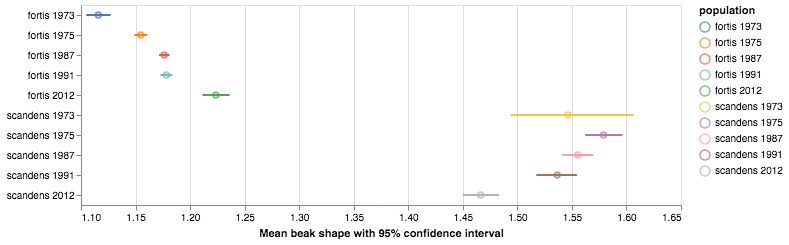

In [69]:
chart = None
for species in names:
    for year in years:
        # Actually calculate statistics
        (mean, mean_shape_conf_int) = mean_beak_shape(df_tidy, year, species)
        name = species + " " + str(year)
        
        # Plotting confidence intervals and points at once is tricky, 
        # so I chose to make several dataframes and several altair 
        # plots, and then overlay them one by one.
        
        # Plot confidence intervals!
        df = pd.DataFrame(data = {"population": [name] * 2, 
                                  "conf_int": mean_shape_conf_int})
        
        ch = alt.Chart(df, height=200, width=600).mark_line(
                         ).encode(x = alt.X("conf_int:Q", 
                                            scale=alt.Scale(zero=False)), 
                                  y = "population:N",
                                  color = alt.Color("population:N"))
        # This takes care of the first chart overlay
        if type(chart) == type(None):
            chart = ch
        else:
            chart = chart + ch
        
        # Plot means!
        df = pd.DataFrame(data = {"population": [name],
                                  "mean": [mean]})
        ch = alt.Chart(df, height=200, width= 600).mark_point(
                         ).encode(x = alt.X("mean:Q", 
                                            scale=alt.Scale(zero=False),
                                            title = "Mean beak shape with 95% confidence interval"), 
                                  y = alt.Y("population:N", 
                                            title = None),
                                  color = alt.Color("population:N"))
        chart = chart + ch
chart

This looks great! The most apparent observation from both plots we have made so far is that the shape of the beak of birds from each poplulation seems to converge over the 40 years of the experiment. We can perform a hypothesis test with the following parameters:

Null hypothesis:  There was no convergence in beak shape. Specifically, the mean beak shape for both species has been stationary over time. 

Test statistic:  initial mean difference in beak shape minus the final mean difference in beak shape.

I will start by computing the test statistic for our experiment:

In [72]:
(mean_f_73, mean_shape_conf_int) = mean_beak_shape(df_tidy, 1973, "fortis")
(mean_f_12, mean_shape_conf_int) = mean_beak_shape(df_tidy, 2012, "fortis")
(mean_s_73, mean_shape_conf_int) = mean_beak_shape(df_tidy, 1973, "scandens")
(mean_s_12, mean_shape_conf_int) = mean_beak_shape(df_tidy, 2012, "scandens")
convergence = (mean_s_73 - mean_f_73) - (mean_s_12 - mean_f_12)
print("Convergence of beak shape for our experiment: %.3f" % convergence)

Convergence of beak shape for our experiment: 0.188


Now I want to isolate the beak shapes for these years and species so that I can perform permutation replicates. 

In [84]:
df = df_tidy[df_tidy["year"] == 1973]
df = df[df["species"] == "fortis"]
shapes_f_73 = df["Shape"].values

df = df_tidy[df_tidy["year"] == 2012]
df = df[df["species"] == "fortis"]
shapes_f_12 = df["Shape"].values

df = df_tidy[df_tidy["year"] == 1973]
df = df[df["species"] == "scandens"]
shapes_s_73 = df["Shape"].values

df = df_tidy[df_tidy["year"] == 2012]
df = df[df["species"] == "scandens"]
shapes_s_12 = df["Shape"].values

In [98]:
@numba.jit(nopython=True)
def draw_perm_sample(x, y):
    """Generate a permutation sample."""
    concat_data = np.concatenate((x, y))
    np.random.shuffle(concat_data)
    return concat_data[:len(x)], concat_data[len(x):]

@numba.jit(nopython=True)
def draw_perm_reps_diff_mean(x, y, size=1):
    """
    Generate array of permuation replicates.
    """
    out = np.empty(size)
    for i in range(size):
        x_perm, y_perm = draw_perm_sample(x, y)
        out[i] = np.mean(x_perm) - np.mean(y_perm)
    return out

Suppose that there was no real convergence in beak shape. In this case, we would be pulling from the same distribution whenever we measured the shape of a bird's beak, regardless of which year it was. This is how I will model the permutation replicates. 

In [120]:
@numba.jit(nopython=True)
def draw_perm_reps_diff_diff_mean(x1, x2, y1, y2, size=1):
    out = np.empty(size)
    for i in range(0, size):
        # s = species, t = time
        # Here I draw two randomized samples from the pool of 1793 
        # and 2012 beak shapes for each species. 
        sample_s1_t1, sample_s1_t2 = draw_perm_sample(x1, x2)
        sample_s2_t1, sample_s2_t2 = draw_perm_sample(y1, y2)
        out[i] = ((np.mean(sample_s1_t1) - np.mean(sample_s2_t1))
                   - (np.mean(sample_s1_t2) - np.mean(sample_s2_t2)))
    return out

In [119]:
reps = draw_perm_reps_diff_diff_mean(shapes_s_73,
                                     shapes_s_12,
                                     shapes_f_73,
                                     shapes_f_12,
                                     size = 10000000)
count = 0
for rep in reps:
    if rep > convergence:
        count += 1
print("p-value: %.8f" %(count / len(reps)))

p-value: 0.00000000


The p-value seems to be so low that it is impossible to calculate in a reasonable amount of time. Thus, the null hypothesis is clearly wrong, and we have validated our suspicion that beak shapes have converged over the duration of the experiment. 